$\Large\textbf{Lab 6.} \large\textbf{Exercise 2.}$



In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from timeit import default_timer as timer
np.random.seed(1000)

In [2]:
def create_data():
    np.random.seed(1000)
    A = np.random.randn(1000, 10)
    x_bar = np.zeros(10)
    for i in range(10):
      if (i+1)%2 == 0:
        x_bar[i] = np.random.uniform(low = i+1, high = i+2)
      else:
        x_bar[i] = np.random.uniform(low = -(i+2), high = -(i+1) )
      x_bar = np.array(x_bar)
      x_bar = x_bar.reshape(10,1)  
    epsilon = np.random.randn(1000, 1)
    y = np.add(np.dot(A, x_bar), epsilon)
    return A, x_bar, y

In [3]:
def evalf(lambd, A, x, y):  
    assert type(lambd) is float
    assert type(x) is np.ndarray 
    assert x.shape[0] == 10 and x.shape[1] == 1 
    assert type(y) is np.ndarray and len(y) == A.shape[0]  
    temp = np.subtract(np.dot(A,x),y)
    fval = np.multiply((lambd/2), np.dot(x.T,x)) + 0.5*np.linalg.norm(temp,2)**2
    return fval

In [4]:
#Now we will define a function which will compute and return the gradient value as a numpy array 
def evalg(lambd, A, x, y):  
    assert type(lambd) is float
    assert type(x) is np.ndarray and x.shape[0] == 10 and x.shape[1] == 1 
    assert type(y) is np.ndarray and len(y) == A.shape[0]
    temp = np.dot(A,x) - y
    grad = np.add(np.multiply(lambd,x), np.dot(A.T,temp))
    return grad

In [5]:
def evalh(lambd, A, x):
    assert type(x) is np.ndarray and x.shape[0] == 10 and x.shape[1] == 1 
    hess = np.multiply(lambd,np.identity(A.shape[1])) + np.matmul(A.T, A)
    return hess

In [6]:
def compute_D_k_newton(lambd, A, x):
    assert type(x) is np.ndarray and x.shape[0] == 10 and x.shape[1] == 1 
    d = np.linalg.inv(evalh(lambd, A, x))
    return d

In [7]:
#line search type 
CONSTANT_STEP_LENGTH = 3
BACKTRACKING_LINE_SEARCH = 2
EXACT_LINE_SEARCH = 1

In [8]:
def compute_steplength_backtracking_scaled_direction(lambd, A, x, y, gradf, D_k, alpha_start, rho, gamma): #add appropriate arguments to the function 
    assert type(x) is np.ndarray and x.shape[0] == 10 and x.shape[1] == 1 
    assert type(y) is np.ndarray and len(y) == A.shape[0]
    assert type(gradf) is np.ndarray and len(gradf) == 10 
    assert type(alpha_start) is float and alpha_start>=0. 
    assert type(rho) is float and rho>=0.
    assert type(gamma) is float and gamma>=0. 
    assert type(D_k) is np.ndarray and len(D_k) == 10  
    alpha = alpha_start
    p_k = -np.dot(D_k,gradf)
    while evalf(lambd, A, np.add(x,np.multiply(alpha,p_k)),y) > np.multiply(gamma*alpha,np.dot(gradf.T,p_k)) + evalf(lambd, A,x,y):
        alpha = rho*alpha  
    return alpha

In [9]:
def find_minimizer_Newtonmethod(lambd, start_x, A, y, tol, line_search_type, *args):
    assert type(lambd) is float
    assert type(start_x) is np.ndarray #do not allow arbitrary type arguments 
    assert start_x.shape[0] == 10 and start_x.shape[1] == 1 
    assert type(tol) is float and tol>=0 
    x = start_x
    g_x = evalg(lambd, A, x, y)
    x_array = [x]
    f_array = [evalf(lambd, A, x,y)]
    if line_search_type == BACKTRACKING_LINE_SEARCH:
        if args is None:
            err_msg = 'Line search type: BACKTRACKING_LINE_SEARCH, but did not receive any args. Please check!'
            raise ValueError(err_msg)
        elif len(args)<3 :
            err_msg = 'Line search type: BACKTRACKING_LINE_SEARCH, but did not receive three args. Please check!'
            raise ValueError(err_msg)
        else:
            alpha_start = float(args[0])
            rho = float(args[1])
            gamma = float(args[2])
    k = 0
    while (np.linalg.norm(g_x) > tol): #continue as long as the norm of gradient is not close to zero upto a tolerance tol
        d_k = compute_D_k_newton(lambd, A, x)
        if line_search_type == BACKTRACKING_LINE_SEARCH:
            step_length = compute_steplength_backtracking_scaled_direction(lambd, A, x, y, g_x, d_k, alpha_start, rho, gamma) 
        elif line_search_type == CONSTANT_STEP_LENGTH: 
            step_length = 1.0
        else:  
            raise ValueError('Line search type unknown. Please check!')
        # Gradient descent steps
        x = np.subtract(x, np.multiply(step_length,np.dot(d_k, g_x))) 
        k += 1 
        g_x = evalg(lambd, A, x, y) 
        x_array.append(x)
        f_array.append(evalf(lambd, A, x,y))
        if k % 4000 == 0:
            print('iter:',k, ' x:', x, ' f(x):', evalf(lambd, A, x, y), ' grad at x:', g_x, ' gradient norm:', np.linalg.norm(g_x))
    return x_array, f_array, k

In [10]:
A, x_bar, y = create_data()

In [11]:
def find_minimizer_BFGS(lambd, start_x, A, y, tol, line_search_type, *args):
    assert type(lambd) is float
    assert type(start_x) is np.ndarray  
    assert start_x.shape[0] == 10 and start_x.shape[1] == 1 
    assert type(tol) is float and tol>=0 
    x = start_x
    g_x = evalg(lambd, A, x, y)
    if line_search_type == BACKTRACKING_LINE_SEARCH:
        if args is None:
            err_msg = 'Line search type: BACKTRACKING_LINE_SEARCH, but did not receive any args. Please check!'
            raise ValueError(err_msg)
        elif len(args)<3 :
            err_msg = 'Line search type: BACKTRACKING_LINE_SEARCH, but did not receive three args. Please check!'
            raise ValueError(err_msg)
        else:
            alpha_start = float(args[0])
            rho = float(args[1])
            gamma = float(args[2])
    k = 0
    B = np.identity(10)
    x_array = [x]
    f_array = [evalf(lambd, A, x,y)]

    while (np.linalg.norm(g_x) > tol): 
        p = -np.dot(B, g_x)
        if line_search_type == BACKTRACKING_LINE_SEARCH:
            d_k = B
            step_length = compute_steplength_backtracking_scaled_direction(lambd, A, x, y, g_x, d_k, alpha_start, rho, gamma) 
        elif line_search_type == CONSTANT_STEP_LENGTH: 
            step_length = 1.0
        else:  
            raise ValueError('Line search type unknown. Please check!')
        x_next = np.add(x, np.multiply(step_length,p)) 
        s_k = x_next - x
        y_k = evalg(lambd, A, x_next,y) - g_x
        mu_k = 1.0/np.dot(y_k.T, s_k)
        temp = (np.identity(10) - np.multiply(mu_k,np.outer(y_k, s_k.T)))
        B = np.dot(temp.T, np.dot(B, temp)) + np.multiply(mu_k, np.outer(s_k, s_k.T))
        k += 1 
        x = x_next
        g_x = evalg(lambd, A, x, y)     
        x_array.append(x)
        f_array.append(evalf(lambd, A, x, y))
        if k % 4000 == 0:
            print('iter:',k, ' x:', x, ' f(x):', evalf(lambd, A, x, y), ' grad at x:', g_x, ' gradient norm:', np.linalg.norm(g_x))
    return x_array, f_array, k

#Q-1 
In the previous exercise, the hessian matrix was ATA but by adding reguralizer term, it is becoming ATA+λI. One cannot assure the invertibility of the matrix ATA, so it is possible that inverse of hessian matrix doesn't exist for previous exercise but the matrix ATA+λI is always invertible because ATA is symmetric and by adding positive diagonal elements to symmetric matrix, We assure the positiveness of eigenvalues.Therefore for λ>0, the inverse of hessian matrix always exist for regularized function in this exercise.

In [12]:
start_xs = []
for i in range(10):
  start_xs.append([0])
start_xs = np.array(start_xs)
my_tol= 1e-5
alpha_start = 0.99
rho = 0.5
gamma = 0.5
lambda_array = [0.001, 0.01, 0.1, 1.0]
x_array_newton2 = [[] for _ in range(len(lambda_array))]
iters_newton2  = [0 for _ in range(len(lambda_array))]
f_array_newton2 = [[] for _ in range(len(lambda_array))]
times_newton2 = [0 for _ in range(len(lambda_array))]
x_array_bfgs2 = [[] for _ in range(len(lambda_array))]
iters_bfgs2  = [0 for _ in range(len(lambda_array))]
f_array_bfgs2 = [[] for _ in range(len(lambda_array))]
times_bfgs2 = [0 for _ in range(len(lambda_array))]
for i in range(len(lambda_array)):
    start_time = timer()
    x_array_newton2[i], f_array_newton2[i], iters_newton2[i] = find_minimizer_Newtonmethod(lambda_array[i], start_xs, A, y, my_tol, BACKTRACKING_LINE_SEARCH, alpha_start, rho, gamma)
    end_time = timer()
    times_newton2[i] = end_time - start_time
    print(f'For lambda = {lambda_array[i]}:')
    print(f"Time taken to find optimal x* by Newton's method for lambda = {lambda_array[i]}: {times_newton2[i]}\nIterations: {iters_newton2[i]}") 
    start_time = timer()
    x_array_bfgs2[i], f_array_bfgs2[i], iters_bfgs2[i]  = find_minimizer_BFGS(lambda_array[i], start_xs, A, y, my_tol, BACKTRACKING_LINE_SEARCH, alpha_start, rho, gamma)
    end_time = timer()
    times_bfgs2[i] = end_time - start_time
    print(f"Time taken to find optimal x* by BFGS method for lambda = {lambda_array[i]}: {times_bfgs2[i]}\nIterations: {iters_bfgs2[i]}") 
    print('')
print()
print(f'Actual x_bar: {x_bar.reshape(1,-1)}')
print('')
x_opt_newton2 = [x_array_newton2[i][-1] for i in range(len(lambda_array))]
x_opt_bfgs2 = [x_array_bfgs2[i][-1] for i in range(len(lambda_array))]

For lambda = 0.001:
Time taken to find optimal x* by Newton's method for lambda = 0.001: 0.02340957300000923
Iterations: 5
Time taken to find optimal x* by BFGS method for lambda = 0.001: 0.03854949600000168
Iterations: 18

For lambda = 0.01:
Time taken to find optimal x* by Newton's method for lambda = 0.01: 0.0026838929999968286
Iterations: 5
Time taken to find optimal x* by BFGS method for lambda = 0.01: 0.0317025330000007
Iterations: 18

For lambda = 0.1:
Time taken to find optimal x* by Newton's method for lambda = 0.1: 0.0027638429999967684
Iterations: 5
Time taken to find optimal x* by BFGS method for lambda = 0.1: 0.03065913500000761
Iterations: 18

For lambda = 1.0:
Time taken to find optimal x* by Newton's method for lambda = 1.0: 0.003417372000001251
Iterations: 5
Time taken to find optimal x* by BFGS method for lambda = 1.0: 0.031946367000003306
Iterations: 18


Actual x_bar: [[-1.06258705  2.94307072 -3.34150552  4.58252615 -5.75947573  6.93512469
  -7.61893094  8.16818187

 **Graph of the values $log(||x^k - x^*||_2$)**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


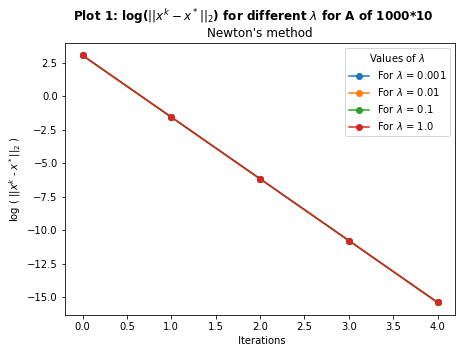

In [13]:
x_opt_newton2 = [x_array_newton2[i][-1] for i in range(len(lambda_array))]
plot_x2 = [[] for _ in range(len(lambda_array))]
for i in range(len(lambda_array)):
    for j in range(len(x_array_newton2[i])):
        plot_x2[i].append(np.log(np.linalg.norm(x_array_newton2[i][j] - x_opt_newton2[i])))
###Plotting###
fig, ax = plt.subplots(1, 1, figsize = (7,5))
fig.suptitle("Plot 1: log($||x^k - x^*||_2$) for different $\lambda$ for A of 1000*10", fontweight= 'bold')
for i in range(len(lambda_array)):
    ax.plot(np.arange(len(x_array_newton2[i])), plot_x2[i], 'o-', label = f"For $\lambda$ = {lambda_array[i]}")
ax.set_title("Newton's method")
ax.set_xlabel(" Iterations")
ax.set_ylabel(r"log ( ||$x^k$ - $x^*||_2$ )")
ax.legend(title = 'Values of $\lambda$')

**Graph of the values $log(||f(x^k) - f(x^*)||_2)$**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


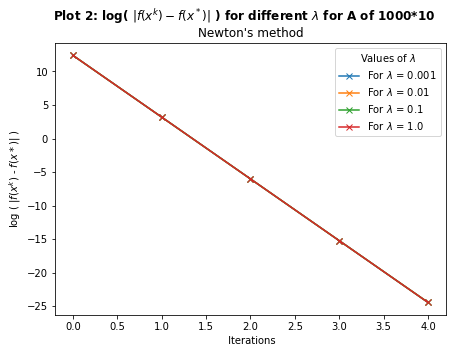

In [14]:
f_opt_newton2 = [f_array_newton2[i][-1] for i in range(len(lambda_array))]
plot_fx2 = [[] for _ in range(len(lambda_array))]
for i in range(len(lambda_array)):
    for j in range(len(f_array_newton2[i])):
        plot_fx2[i].append(np.log(np.linalg.norm(f_array_newton2[i][j] - f_opt_newton2[i])))
##Plotting###
fig, ax = plt.subplots(1,1, figsize = (7,5))
fig.suptitle("Plot 2: log( $|f(x^k) - f(x^*)|$ ) for different $\lambda$ for A of 1000*10", fontweight= 'bold')
for i in range(len(lambda_array)):   
    ax.plot(np.arange(len(f_array_newton2[i])), plot_fx2[i], 'x-', label = f"For $\lambda$ = {lambda_array[i]}")
ax.set_title("Newton's method")
ax.set_xlabel(" Iterations")
ax.set_ylabel(r"log ( |$f(x^k)$ - $f(x*)$| )")
ax.legend(title = 'Values of $\lambda$')



$\large\textbf{Question 4.}$
$x^*$ and $\bar{x}$ are almost equal with given precision of error. The optimal solution $x^*$ is same for both Newton's and BFGS methods for all the given starting points. Plot between $log(||x^k-x^*||)$ and Iterations for Newton's method and BFGS method is Q-linear for all given starting points. The difference is that it is Q-linear for Newton's method from starting but it is Q-linear for BFGS after few iterations. Plot between $log(|f(x^k)-f(x^*)|)$ and Iterations for Newton's method and BFGS method is same as plot between $log(||x^k-x^*||)$ and Iterations with different scaling on both axises i.e. it has same behaviour. The Newton's method is faster than BFGS method because it is Q-linear from starting but BFGS is Q-linear after few iterations.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


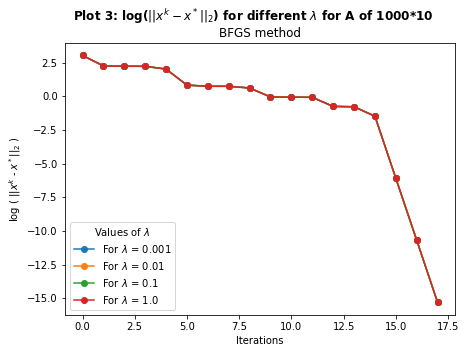

In [15]:
x_opt_bfgs2 = [x_array_bfgs2[i][-1] for i in range(len(lambda_array))]
plot_x_bfgs2 = [[] for _ in range(len(lambda_array))]
for i in range(len(lambda_array)):
    for j in range(len(x_array_bfgs2[i])):
        plot_x_bfgs2[i].append(np.log(np.linalg.norm(x_array_bfgs2[i][j] - x_opt_bfgs2[i])))
###Plotting###
fig, ax = plt.subplots(1,1, figsize = (7,5))
fig.suptitle("Plot 3: log($||x^k - x^*||_2$) for different $\lambda$ for A of 1000*10", fontweight= 'bold')
for i in range(len(lambda_array)):   
    ax.plot(np.arange(len(x_array_bfgs2[i])), plot_x_bfgs2[i], 'o-', label = f"For $\lambda$ = {lambda_array[i]}")
ax.set_title("BFGS method")
ax.set_xlabel("Iterations")
ax.set_ylabel(r"log ( ||$x^k$ - $x^*||_2$ )")
ax.legend(title = 'Values of $\lambda$')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


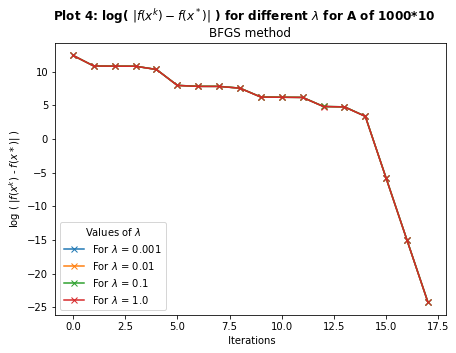

In [16]:
f_opt_bfgs2 = [f_array_bfgs2[i][-1] for i in range(len(lambda_array))]
plot_fx_bfgs2 = [[] for _ in range(len(lambda_array))]
for i in range(len(lambda_array)):
    for j in range(len(f_array_bfgs2[i])):
        plot_fx_bfgs2[i].append(np.log(np.linalg.norm(f_array_bfgs2[i][j] - f_opt_bfgs2[i])))
###Plotting###
fig, ax = plt.subplots(1, 1, figsize = (7,5))
fig.suptitle("Plot 4: log( $|f(x^k) - f(x^*)|$ ) for different $\lambda$ for A of 1000*10", fontweight= 'bold')
for i in range(len(lambda_array)):
    ax.plot(np.arange(len(f_array_bfgs2[i])), plot_fx_bfgs2[i], 'x-', label = f"For $\lambda$ = {lambda_array[i]}")
ax.set_title("BFGS method")
ax.set_xlabel(" Iterations")
ax.set_ylabel(r"log ( |$f(x^k)$ - $f(x*)$| )")
ax.legend(title = 'Values of $\lambda$')

Question 5 $x^*$ and $\bar{x}$ are almost equal with given precision of error in their components for both Newton's method and BFGS method for all the given $\lambda$ values but this error is becoming largere as we are increasing $\lambda$ values. The optimal solution $x^*$ is not same for both Newton's method and BFGS method for all the given $\lambda$ values because of the regularized term we added in the main function. Plot between $log(||x^k-x^*||)$ and Iterations for Newton's method and BFGS method is Q-linear for all given $\lambda$ values, the difference is that it is Q-linear for Newton's method from starting but it is Q-linear for BFGS after 2 iterations. Plot between $log(|f(x^k)-f(x^*)|)$ and Iterations for Newton's method and BFGS method is same as plot between $log(||x^k-x^*||)$ and Iterations with different scaling on both axes i.e. it has same behaviour. The Newton's method is faster than BFGS method because it is Q-linear from starting but BFGS is Q-linear after few iterations.

$\large\textbf{Answer 6.}$

**Using Newton's Method**

$\lambda$ | $x^*$ |$\bar{x}$ | $f(x^*)$|$f(\bar{x})$ | Time
:----:|:---:|:---:|:---:|:---:|:---:
0.001 | (-3.8946358219518213, 6.158177582958033) | (-3.8864520683267783, 6.149324214707549) | 4754.37010610238 | 4755.077913531231 | 0.010154251000130898
0.1 | (-3.8945965053733778, 6.158114664714515) | (-3.8864520683267783, 6.149324214707549) | 4756.998100640705 | 4757.697389081092 | 0.005226085000685998
1.0 | (-3.8942391185106873, 6.157542739927886) | (-3.8864520683267783, 6.149324214707549) | 4780.886505582736 | 4781.510803170738 | 0.004265139001290663
10.0 | (-3.8906688517338135, 6.151829326691304) | (-3.8864520683267783, 6.149324214707549) | 5019.527566433189 | 5019.644944067193 | 0.0037762970005132956
100.0 | (-3.855322930258129, 6.0952730071477506) | (-3.8864520683267783, 6.149324214707549) | 7381.886450401795 | 7400.986353031748 | 0.003730933000042569